# Evaluate Racmo 2.4p1 Against Mass Balance Estimates
---

This notebook examines RACMO 2.4p1 output and compares to previous mass balance numbers. The results differ signficantly with both Antarctic totals (typically 240-2500 Gt/yr) by the Utrecht group the numbers in the Rignot et al, 2018; www.pnas.org/cgi/doi/10.1073/pnas.1812883116) paper.

It's quite likely I am misinterpretting the data or doing something stupid. If so, I sure would like to know what.

In [1]:
import xarray as xr
import rioxarray as rioxr
import numpy as np
import matplotlib.pylab as plt
import utilities as u
import pyproj
from datetime import datetime, timedelta
import geopandas as gpd
from scipy.interpolate import griddata

In [2]:
def xytoll(x, y, epsg=3031):
    xytollXform = pyproj.Transformer.from_crs(f"EPSG:{epsg}", "4326")
    lat, lon = xytollXform.transform(x, y)
    return lat, lon

def lltoxy(lat, lon, epsg=3031):
    xytollXform = pyproj.Transformer.from_crs( "4326", f"EPSG:{epsg}")
    x, y = xytollXform.transform(lat, lon)
    return x, y

In [4]:
basepath='../RACMO2.4'

Read the data set and average over the time series. As far as I know there are no weird data that could screw the average up. Files provided by Tyler Sutterly. 

In [5]:
SMBOrig =  xr.open_dataset(f'{basepath}/RACMO2_4p1_AIS.dir/smbgl_monthlyS_PXANT11_RACMO24p1v5_ERA5_196001_202501.nc', decode_times=False)
SMBAvg = np.squeeze(SMBOrig.smbgl.mean(dim='time'))
Masks = xr.open_dataset(f'{basepath}/PXANT11_maskgrounded2d.nc')

Get grid. 

In [6]:
lat2d = SMBOrig.lat.data
lon2d = SMBOrig.lon.data
xg, yg = lltoxy(lat2d, lon2d)

Make some regional masks. 

In [7]:
maskNoAp =  np.full(SMBAvg.shape, np.nan)
maskAp =  np.full(SMBAvg.shape, np.nan)
maskAll = np.full(SMBAvg.shape, np.nan)
maskAll[Masks.Basins.data >= 0] = 1
maskNoAp[Masks.Basins.data < 24] = 1
maskAp[Masks.Basins.data >= 24] = 1

Show some of the these quantities. 

Text(0.5, 1.0, 'EAIS/WAIS (no AP) mask')

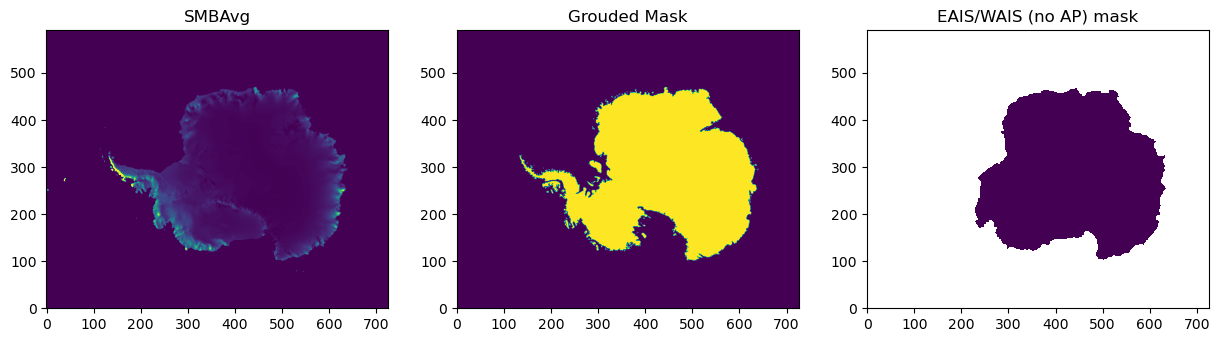

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(SMBAvg, origin='lower', vmin=0, vmax=200)
axes[0].set_title('SMBAvg')
axes[1].imshow(Masks.maskgrounded2d, origin='lower')
axes[1].set_title('Grouded Mask')
axes[2].imshow(maskNoAp, origin='lower')
axes[2].set_title('EAIS/WAIS (no AP) mask')

## Compute Various Integrated Estimates

In [9]:
print(f'Grounded SMB {np.nansum(Masks.maskgrounded2d * Masks.Area*1e6 *  SMBAvg/100).item()/1e9:.0f} Gt/yr'
      f' area {np.nansum(Masks.maskgrounded2d * Masks.Area).item():.4e} km^2')
print(f'Grounded SMB exclude AP {np.nansum(Masks.maskgrounded2d * maskNoAp * Masks.Area*1e6 * SMBAvg/100).item()/1e9:.0f}'
     f' area {np.nansum(Masks.maskgrounded2d * maskNoAp * Masks.Area).item():.4e} km^2')
print(f'Grounded SMB AP only {np.nansum(Masks.maskgrounded2d * maskAp * Masks.Area*1e6 *  SMBAvg/100).item()/1e9:.0f}'
      f' area {np.nansum(Masks.maskgrounded2d * maskAp * Masks.Area):.4e} km^2')
print(f'All basins {np.nansum(maskAll * Masks.Area * 1e6 * SMBAvg/100).item()/1e9:.0f}'
      f' area {np.nansum(maskAll*Masks.Area).item():.4e} km^2')
print(f'All EAIS/WAIS {np.nansum(maskNoAp*Masks.Area*1e6 *  SMBAvg/100).item()/1e9:.0f}'
     f' area {np.nansum(maskNoAp*Masks.Area).item():.4e} km^2')
print(f'All AP {np.nansum(maskAp * Masks.Area*1e6 * SMBAvg/100).item()/1e9:.0f}'
     f' area {np.nansum(maskAp*Masks.Area).item():.4e}')

Grounded SMB 1649 Gt/yr area 1.2253e+07 km^2
Grounded SMB exclude AP 1404 area 1.1956e+07 km^2
Grounded SMB AP only 245 area 2.9467e+05 km^2
All basins 2038 area 1.3857e+07 km^2
All EAIS/WAIS 1713 area 1.3407e+07 km^2
All AP 325 area 4.4949e+05


These numbers quite different that earlier numbers. van Wessem et al (2018) gives 2229 from Racmo 2.3, excluding the AP (compare to 1713 above). The total including shelves from val Dalum (2025) is 2456 for all of Antarctica (compared to 2038 above). Rignot et al (2018) give 2098 for the entire grounded ice sheet 2098 (compared to 1649 above). Given these results, my first instinct is that I have made a mistake. I have double-checked everything as much as possible and have run into a wall. I have run with other versions of RACMO and gotten similar results. I would really like to understand the differences one way or another. 

## Resample to XY grid

Create output grid

In [10]:
dx = 5e3  # I have run smaller spacings with similar results.
dy = dx
x, y  = np.arange(-2800e3, 2802e3, dx), np.arange(-2800e3, 2802e3, dx)
xx, yy = np.meshgrid(x, y)
#lat, lon = xytoll
lat, lon = xytoll(xx, yy)
lat1 = lat.reshape(xx.shape)
lon1 = lon.reshape(xx.shape)
extent = [np.min(xx), np.max(xx), np.min(yy), np.max(yy) ]
# polar stero area correction factor.
p = pyproj.Proj("EPSG:3031") 
scale = 1./p.get_factors(lon1, lat1).areal_scale

Interpolate to xy grids. 

In [11]:
points = np.column_stack((xg.ravel(), yg.ravel()))
values = (SMBAvg.data).ravel()
valuesBasin = (Masks.Basins.data).ravel()
valuesGrounded = (Masks.maskgrounded2d.data).ravel()
SMB_interp = griddata(points, values, (xx, yy), method='nearest')
SMB_basins = griddata(points, valuesBasin, (xx, yy), method='nearest')
SMB_grounded = griddata(points, valuesGrounded, (xx, yy), method='nearest')
SMB_interp = SMB_interp.reshape(lat1.shape)
SMB_basins = SMB_basins.reshape(lat1.shape)
SMB_grounded = SMB_grounded.reshape(lat1.shape)

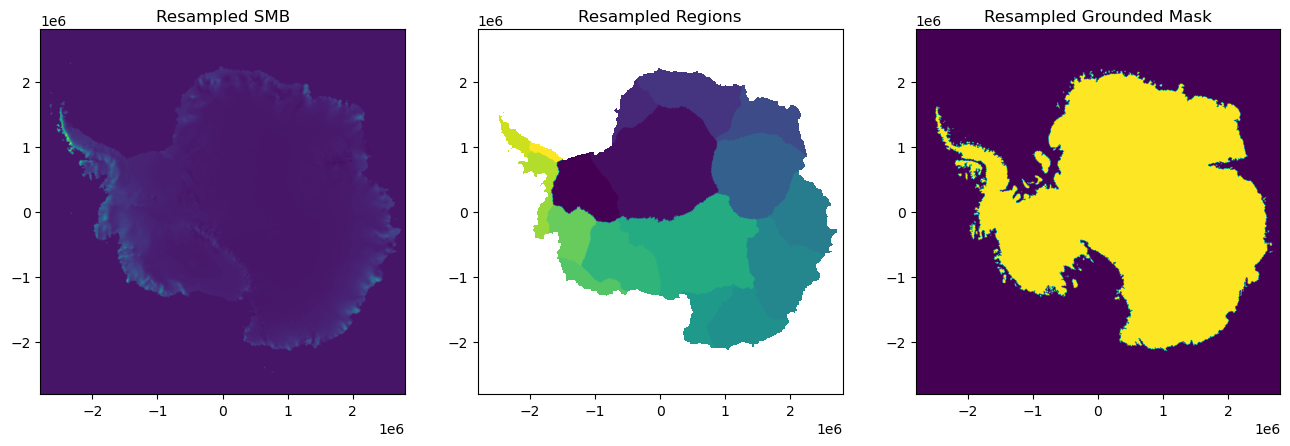

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16,8))
for ax, var, title in zip(axes.flatten(), [SMB_interp, SMB_basins, SMB_grounded], ['Resampled SMB', 'Resampled Regions', 'Resampled Grounded Mask']):
    ax.imshow(var, extent=extent, origin='lower')
    ax.set_title(title)

## Save as Tiffs

In [13]:
import rasterio
from rasterio.transform import from_origin
# Define transform (origin = top-left)
transform = from_origin(np.min(xx)-dx/2, np.max(yy) +dy*.5, dx, dy)  # y[-1] + dy assumes y descending

with rasterio.open(
    "RACMO2.4p1.tif", "w",
    driver="GTiff",
    height=SMB_interp.shape[0],
    width=SMB_interp.shape[1],
    count=1,
    dtype=SMB_interp.dtype,
    crs=f"EPSG:3031",
    transform=transform,
) as dst:
    dst.write(np.flipud(SMB_interp/100.), 1)

This tiff aligns well with other data sets when viewed in QGIS, indicating everything is in the right place.

## Create Data Arrays

Its helpful to have some of these as data arrays.

In [14]:
da = xr.DataArray(
    SMB_interp,
    dims=["y", "x"],
    coords={"x": x, "y": y},
    name="SMB"
)
# cryptically named SMB (courtesy chatGPT)
da = da.rio.write_crs("EPSG:3031")

daScale = xr.DataArray(
    scale,
    dims=["y", "x"],
    coords={"x": x, "y": y},
    name="Scale"
)
# Xy scale factor
daScale = daScale.rio.write_crs("EPSG:3031")

daRegion = xr.DataArray(
    SMB_basins,
    dims=["y", "x"],
    coords={"x": x, "y": y},
    name="Region"
)
# Region mask (often called basins, used region here to distinguish from indivual glacier basins below)
daRegion = daRegion.rio.write_crs("EPSG:3031")

daGrounded = xr.DataArray(
    SMB_grounded,
    dims=["y", "x"],
    coords={"x": x, "y": y},
    name="Grounded"
)
# Grounded mask
daGrounded = daGrounded.rio.write_crs("EPSG:3031")

## Basin Analysis

Compute basin by basin calculation (eg. emulating Rignot 2018). 

In [15]:
basins = gpd.read_file('/Volumes/insar11/ian/ModelingDataSets/Antarctica/Groundinglines/Basins_Antarctica_v02.shp')

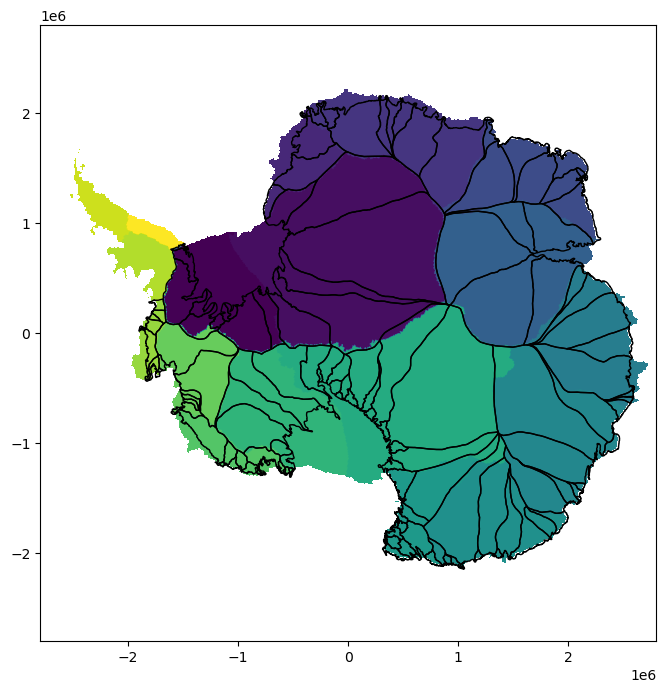

In [16]:
SMBbyBasin ={}
regions = {}
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(daRegion, origin='lower', extent=extent)
all_touched = False
for _, row in basins.iterrows():
    geom = gpd.GeoSeries([row.geometry], crs=basins.crs)
    # mask out everything but the current basin
    masked = da.rio.clip(geom.geometry, geom.crs, drop=False, all_touched=all_touched)
    maskedRegion = daRegion.rio.clip(geom.geometry, geom.crs, drop=False, all_touched=all_touched)
    maskedScale = daScale.rio.clip(geom.geometry, geom.crs, drop=False, all_touched=all_touched)
    # Match region names with basins. Use 0 for islands.
    SMBbyBasin[row.NAME] = np.nansum((masked/100 * maskedScale * dx**2).data)
    if row.NAME != 'Islands':
        regions[row.NAME] = np.round(np.nanmean(maskedRegion))
    else:
        # uncomment to remove islands
        #SMBbyBasin[row.NAME] = 0
        regions[row.NAME] = 0
    # Don't plot AP in this example (islands) 
    if  regions[row.NAME] < 24 and regions[row.NAME] > 0:
    #    ax.imshow(masked, origin='lower', extent=(
    #        masked.x.min(), masked.x.max(), masked.y.min(), masked.y.max()), vmin=0, vmax=200)
        geom.plot(ax=ax, facecolor='none')
    #break

In [17]:
print(f'Grounded Ice Sheet  {np.sum([SMBbyBasin[key] for key in SMBbyBasin])/1e9:.0f} Gt/yr')
print(f'Grounded Ice Sheet no AP {np.sum([SMBbyBasin[key] for key in SMBbyBasin if regions[key] < 24])/1e9:.0f} Gt/yr')

Grounded Ice Sheet  1650 Gt/yr
Grounded Ice Sheet no AP 1421 Gt/yr


These values are consistent with the values above by (1649, 1404).

In [18]:
maskAllxy  = np.isfinite(daRegion).astype(int)
maskNoAPxy = (daRegion < 24).astype(int)
maskAPxy = (daRegion >= 24).astype(int)

In [19]:
print(f'Full Ice sheet/shelves {np.nansum(maskAllxy * da * daScale/100) * dx**2 /1e9:.0f} Gt/yr')
print(f'Full Grounded ice sheet {np.nansum(daGrounded * da * daScale/100) * dx**2 /1e9:.0f} Gt/yr')
print(f'Ice sheet/shelves No AP {np.nansum(maskNoAPxy * da * daScale/100) * dx**2 /1e9:.0f} Gt/yr')
print(f'Grounded Ice sheet No AP {np.nansum(maskNoAPxy * daGrounded * da * daScale/100) * dx**2 /1e9:.0f} Gt/yr')
print(f'AP Only with shelves {np.nansum(maskAPxy * da * daScale/100) * dx**2 /1e9:.0f} Gt/yr')

Full Ice sheet/shelves 2054 Gt/yr
Full Grounded ice sheet 1662 Gt/yr
Ice sheet/shelves No AP 1727 Gt/yr
Grounded Ice sheet No AP 1415 Gt/yr
AP Only with shelves 328 Gt/yr


These also agree well with the numbers above. 

So why are these numbers consistently below published results. I assume SMB is cm/yr w.e.. Is that correct?